# visualising a custom NIfTI volumetric atlas using yabplot

This notebook demonstrates how to convert a custom NIfTI subcortical atlas (in this case [Tian subcortical atlas 2020)](https://github.com/yetianmed/subcortex) into the GIfTI surface format suitable for visualising with `yabplot.plot_subcortical` function and coloring with actual values.

**Input:** 
- `.nii.gz` volumetric atlas
- `.txt` label file (region names, assuming 1-based line indexing)
    - formatting can depend on atlas, so parsing the file can vary

**Output:**
- Folder of `.gii` files (one per region) ready for `custom_atlas_path` parameter

In [30]:
import os
import numpy as np
import nibabel as nib
from skimage import measure

atlas_path = '/Users/to8050an/Documents/GitHub/yabplot/examples/exampledata/Tian2020MSA/3T/Subcortex-Only/Tian_Subcortex_S1_3T_1mm.nii.gz'
label_path = '/Users/to8050an/Documents/GitHub/yabplot/examples/exampledata/Tian2020MSA/3T/Subcortex-Only/Tian_Subcortex_S1_3T_label.txt'

output_dir = 'exampledata/my_custom_atlas'
os.makedirs(output_dir, exist_ok=True)

In [31]:
## step 1: parse the label file
# the Tian atlas label file is a simple list of names. 
# we assume the line number corresponds to the integer ID in the NIfTI file (1-based index).
# e.g., line 1 -> ID 1 -> "HIP-rh"

print("Parsing labels...")
rois = {}
with open(label_path, 'r') as f:
    # use enumerate starting at 1 to generate IDs matching the NIfTI mask
    for idx, line in enumerate(f, start=1):
        name = line.strip()
        if name:
            # cleanup name: replace hyphens/spaces with underscores for safe filenames
            clean_name = name.replace(' ', '_')
            
            # yabplot expects names like "Left_Thalamus" or "Thalamus_L" for auto-side detection.
            # the Tian atlas uses "-rh" and "-lh". we standardize this to "_R" and "_L".
            # "HIP-rh" -> "HIP_R"
            if clean_name.endswith('-rh') or clean_name.endswith('_rh'):
                clean_name = clean_name.replace('-rh', '_R').replace('_rh', '_R')
            elif clean_name.endswith('-lh') or clean_name.endswith('_lh'):
                clean_name = clean_name.replace('-lh', '_L').replace('_lh', '_L')
                
            rois[idx] = clean_name
            print(f"ID {idx}: {name} -> {clean_name}")

print(f"Parsed {len(rois)} regions.")
print(f"Example: ID 1 maps to '{rois[1]}'")



Parsing labels...
ID 1: HIP-rh -> HIP_R
ID 2: AMY-rh -> AMY_R
ID 3: pTHA-rh -> pTHA_R
ID 4: aTHA-rh -> aTHA_R
ID 5: NAc-rh -> NAc_R
ID 6: GP-rh -> GP_R
ID 7: PUT-rh -> PUT_R
ID 8: CAU-rh -> CAU_R
ID 9: HIP-lh -> HIP_L
ID 10: AMY-lh -> AMY_L
ID 11: pTHA-lh -> pTHA_L
ID 12: aTHA-lh -> aTHA_L
ID 13: NAc-lh -> NAc_L
ID 14: GP-lh -> GP_L
ID 15: PUT-lh -> PUT_L
ID 16: CAU-lh -> CAU_L
Parsed 16 regions.
Example: ID 1 maps to 'HIP_R'


In [32]:
## step 2: convert volumes to surfaces (marching cubes)
# we iterate through each ROI ID, mask the volumetric data to isolate that region, 
# extract the isosurface using marching cubes, apply the affine transform (to map voxels to real-world MNI coordinates), 
# and save the result as a GIfTI file.

# load the volumetric atlas
img = nib.load(atlas_path)
data = img.get_fdata()
affine = img.affine

print(f"Processing {len(rois)} regions from NIfTI volume...")
for roi_id, name in rois.items():
    # 1. create binary mask for this region
    mask = (data == roi_id).astype(np.uint8)
    
    # skip empty regions if any exist
    if np.sum(mask) == 0:
        print(f"Skipping {name} (ID {roi_id}): No voxels found.")
        continue

    # 2. marching cubes
    # extracts the surface mesh from the 3D mask. 
    # level=0.5 draws the surface halfway between 0 (background) and 1 (roi)
    verts, faces, normals, values = measure.marching_cubes(mask, level=0.5)
    
    # 3. apply affine transform
    # marching_cubes returns coordinates in voxel indices (i,j,k).
    # we must multiply by the affine matrix to get real-world coordinates (x,y,z).
    verts_mni = nib.affines.apply_affine(affine, verts)
    
    # 4. create GIfTI image
    # yabplot expects standard NIfTI intent codes for points and triangles
    coord_array = nib.gifti.GiftiDataArray(
        data=verts_mni.astype(np.float32), 
        intent='NIFTI_INTENT_POINTSET'
    )
    face_array = nib.gifti.GiftiDataArray(
        data=faces.astype(np.int32), 
        intent='NIFTI_INTENT_TRIANGLE'
    )
    gii = nib.gifti.GiftiImage(darrays=[coord_array, face_array])
    
    # 5. save
    # we use a standard naming convention so yabplot finds them easily
    out_name = os.path.join(output_dir, f"{name}.surf.gii")
    nib.save(gii, out_name)

print("Conversion complete!")
print(f"Surfaces saved to: {os.path.abspath(output_dir)}")

Processing 16 regions from NIfTI volume...
Conversion complete!
Surfaces saved to: /Users/to8050an/Documents/GitHub/yabplot/examples/exampledata/my_custom_atlas


found 16 regions in custom folder.


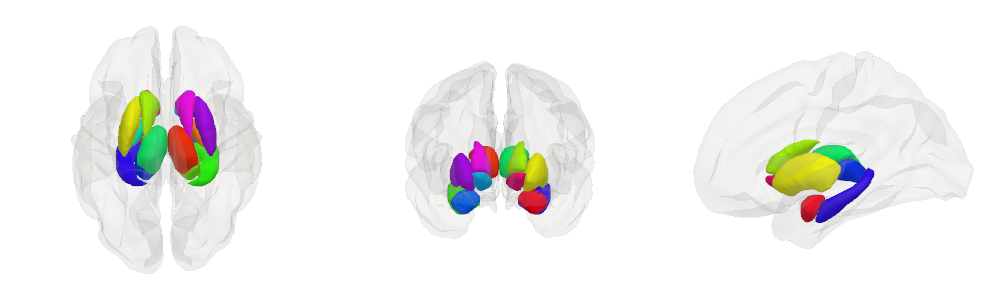

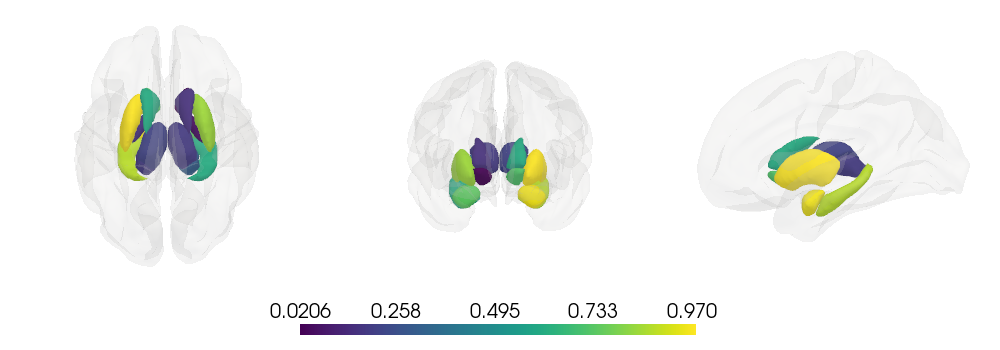

In [33]:
## step 3: visualize with yabplot
# now we use `plot_subcortical` with the `custom_atlas_path` argument.

# --- temporary workaround for yabplot importing (TODO - remove later when package ready)
import sys
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.insert(0, project_root)
# ---

import yabplot as yabp

# verify regions were found
# this checks your output directory and lists the regions yabplot sees
regions = yabp.get_atlas_regions(atlas=None, category='subcortical', custom_atlas_path=output_dir)
print(f"found {len(regions)} regions in custom folder.")

# 3. plot the atlas
# we can customize the smoothing of the regions here with custom_atlaas_proc argument
yabp.plot_subcortical(
    custom_atlas_path=output_dir,
    figsize=(1000, 300),
    views=['superior', 'anterior', 'left_lateral'],
    custom_atlas_proc={'smooth_i': 20, 'smooth_f': 0.5}, # Slightly more smoothing
    style='sculpted'
)

# 4. plot the atlas with data and different lighting
# create dummy data matching the region count
data = np.random.rand(len(regions))
yabp.plot_subcortical(
    data=data,
    custom_atlas_path=output_dir,
    figsize=(1000, 350),
    cmap='viridis',
    views=['superior', 'anterior', 'left_lateral'],
    custom_atlas_proc={'smooth_i': 20, 'smooth_f': 0.6}, # Slightly more smoothing
    style='default'
)